# Using AimqbGroup Parser to Compute Group Properties

## Background

Properties of functional groups, R, are available to be computed in `aiida-aimall`. The authors have published numerous works calculating these properties. For most properties, group properties are available by simply summing the atomic properties of the atoms in the group. The exception is for quadrupole moments, where the formula from Laidig's 1991 paper is used.

$$ \textbf{Q}(R) = \frac{1}{2}\sum_{\Omega\in R} [ 3( q(\Omega)\chi_\Omega^\alpha\chi_\Omega^\beta + \frac{Q_{\alpha\beta}(\Omega)+\delta_{\alpha\beta}\braket{r^2}_\Omega}{3} + \chi_\Omega^\beta \mu^{p,\alpha}(\Omega) + \chi_\Omega^\alpha \mu^{p, \beta}(\Omega)) - \delta_{\alpha\beta}(Q_{\gamma\gamma}) ]$$

Further, delocalization indeces between the substituent and the substrate to which is attached are also calculated by summing pairwise delocalization indeces between atoms in the group and those not.

$$ DI(R,G) = \sum_{\Omega\in R}\sum_{\Lambda\in G} DI(\Omega,\Lambda)$$

The group properties are designed to be calculated in a molecule treated in only two parts - the substituent, R and the substrate, G. All atoms are either assigned to either the substrate or substituent, and the substituent should be connected amongst itself. Inputs for the atoms can be provided to `AimqbCalculation` to enable use of the `AimqbGroupParser`. These are provided as `group_atoms`, a List of atom integer numeric labels corresponding to the atom order in the input file. Further, the atom of the substituent attached to the substrate should be given as `attached_atom_int`. An example is shown here for the methyl substituent attached to a generic substrate G.

![alt text](images/coordsystem.png "Title")

Default parameters are provided. By the authors' convention, 1 is the default for the atom in the substituent that is attached to the substrate. Further, the default substrate is assumed to be a single atom, with numeric label 2. Therefore, the default value of `group_atoms` is every atom in the molecule whose label is not 2. If the `group_atoms` and `attached_atom_int` are not provided, these values are used. 

With the definitions in place, computing group properties with `AimqbGroupCalculation` is simple, providing this additional input, and specifying the `AimqbGroupParser`.

## Setting Up `AimqbCalculations` with `AimqbGroupParser`

In [5]:
from aiida import load_profile
from aiida.orm import load_code, load_node, List, Int
from aiida.engine import submit
from aiida.plugins import CalculationFactory, DataFactory

# Define inputs similarly to the base AimqbCalculation tutorial
load_profile()
AimqbParameters = DataFactory('aimall.aimqb')
AimqbCalculation = CalculationFactory('aimall.aimqb')
input_file = load_node('b6710cfe')
aim_code = load_code('aimall@localhost')
aim_input = AimqbParameters({'nproc':2,'naat':2,'atlaprhocps':True})
builder = AimqbCalculation.get_builder()

builder.parameters = aim_input
builder.file = input_file
builder.code = aim_code
builder.metadata.options.resources = {"num_machines": 1, "tot_num_mpiprocs": 2}

# New inputs for the group parser, here there are 18 atoms, and only atom 2 (index 1) is not in the substituent
builder.metadata.options.parser_name = "aimall.group"
builder.group_atoms = List([x + 1 for x in range(0, 18) if x != 1])
builder.attached_atom_int = Int(1)
calc_node = submit(builder)

## `AimqbGroupParser` Output

The provenance graph will have the same structure as that for using the `AimqbBaseParser`. The difference is in the keys of output_parameters.

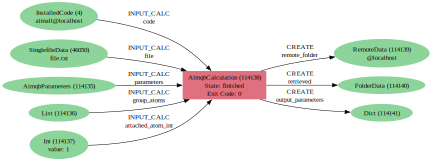

In [7]:
from aiida.tools.visualization import Graph
graph = Graph(graph_attr={"size": "6,6!", "rankdir": "LR"})
graph.add_incoming(calc_node.uuid,
                   annotate_links="both")
graph.add_outgoing(calc_node.uuid,
                   annotate_links="both")
graph.graphviz

In [8]:
out_dict = load_node(114141).get_dict()
print(out_dict.keys())

dict_keys(['cc_properties', 'bcp_properties', 'graph_descriptor', 'group_descriptor', 'atomic_properties'])


Here, we see we have the usual output from before - cc_properties, bcp_properties, atomic_properties. These are identical to the AimqbBaseParser. The group parser additionall provides the graph_descriptor and group_descriptor keys. The graph descriptor focuses on properties of the atom that is attached to the substrate - it collects the atomic properties for that atom, and the CC and BCP properties for all charge concentrations and BCPs associated with it. In this way, the substituent is described by these properties.

In [9]:
out_dict['graph_descriptor'].keys()

dict_keys(['attached_cc_props', 'attached_bcp_props', 'attached_atomic_props'])


The group descriptor focuses on summing the integrated properties as described above. It has similar keys the keys of a given atom in atomic_properties, but summed over the atoms defined in group_atoms in the input.

In [11]:
out_dict['group_descriptor'].keys()

dict_keys(['K', 'q', 'Vol', 'Mu_X', 'Mu_Y', 'Mu_Z', 'Q_xx', 'Q_xy', 'Q_xz', 'Q_yy', 'Q_yz', 'Q_zz', '|Mu|', 'K_Scaled', 'Mu_Bond_X', 'Mu_Bond_Y', 'Mu_Bond_Z', '|Mu_Bond|', 'Mu_Intra_X', 'Mu_Intra_Y', 'Mu_Intra_Z', '|Mu_Intra|'])